In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

In [2]:
#Read dataset
df = pd.read_csv('./20180221/02-21-2018_small.csv') 


In [3]:
df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,17,21/02/2018 10:08:51,119893441,309629,0,9908128,0,32,32,...,8,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-LOIC-UDP
1,80,17,21/02/2018 10:08:52,119745803,259444,0,8302208,0,32,32,...,8,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-LOIC-UDP
2,80,17,21/02/2018 10:08:53,119965025,248800,0,7961600,0,32,32,...,8,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-LOIC-UDP
3,80,17,21/02/2018 10:08:54,119999991,272337,0,8714784,0,32,32,...,8,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-LOIC-UDP
4,80,17,21/02/2018 10:08:54,119820553,219539,0,7025248,0,32,32,...,8,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-LOIC-UDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,80,6,21/02/2018 02:30:37,715,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-HOIC
9995,80,6,21/02/2018 02:24:17,4329,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-HOIC
9996,80,6,21/02/2018 02:13:00,14454,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-HOIC
9997,80,6,21/02/2018 02:17:14,2880,3,4,249,935,249,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-HOIC


In [4]:
df.Label.value_counts()

Label
DDOS attack-HOIC        5419
Benign                  2850
DDOS attack-LOIC-UDP    1730
Name: count, dtype: int64

In [5]:
df.dtypes

Dst Port           int64
Protocol           int64
Timestamp         object
Flow Duration      int64
Tot Fwd Pkts       int64
                  ...   
Idle Mean        float64
Idle Std         float64
Idle Max           int64
Idle Min           int64
Label             object
Length: 80, dtype: object

### Preprocessing (normalization and padding values)

In [6]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

In [7]:
df = df.drop(columns=['Timestamp'])

In [8]:
features

Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Siz

### Data sampling
Due to the space limit of GitHub files and the large size of network traffic data, we sample a small-sized subset for model learning using **k-means cluster sampling**

In [9]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [10]:
df.Label.value_counts()

Label
1    5419
0    2850
2    1730
Name: count, dtype: int64

In [11]:
# retain the minority class instances and sample the majority class instances
df_minor = df[(df['Label']==2)]
df_major = df.drop(df_minor.index)

In [12]:
X = df_major.drop(['Label'],axis=1) 
y = df_major.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [13]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=100, random_state=0).fit(X)

In [14]:
klabel=kmeans.labels_
df_major['klabel']=klabel

In [15]:
df_major['klabel'].value_counts()

klabel
77    704
24    623
14    363
43    358
0     334
     ... 
41     17
89     15
45     12
57      4
95      1
Name: count, Length: 100, dtype: int64

In [16]:
cols = list(df_major)
cols.insert(80, cols.pop(cols.index('Label')))
df_major = df_major.loc[:, cols]

In [17]:
df_major

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
1730,1.445141,-0.459748,-0.455357,-0.442087,0.665386,-0.441737,0.295182,1.550735,-0.460412,1.465980,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,66,0
1731,1.753132,-0.459748,-0.455364,-0.442087,0.665386,-0.441737,0.442026,1.550735,-0.460412,1.465980,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,51,0
1732,1.597544,-0.459748,-0.455367,-0.442087,0.665386,-0.441737,0.194023,1.550735,-0.460412,1.465980,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,31,0
1733,1.356760,-0.459748,-0.455362,-0.442087,0.665386,-0.441737,0.161392,1.550735,-0.460412,1.465980,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,35,0
1734,1.501743,-0.459748,-0.455370,-0.442087,0.665386,-0.441737,0.376762,1.550735,-0.460412,1.465980,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,89,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,-0.624402,-0.459748,-0.455377,-0.442153,-0.750790,-0.442373,-0.654406,-0.756478,-0.460412,-0.891368,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,34,1
9995,-0.624402,-0.459748,-0.455296,-0.442153,-0.750790,-0.442373,-0.654406,-0.756478,-0.460412,-0.891368,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,0,1
9996,-0.624402,-0.459748,-0.455069,-0.442153,-0.750790,-0.442373,-0.654406,-0.756478,-0.460412,-0.891368,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,77,1
9997,-0.624402,-0.459748,-0.455328,-0.442131,2.081561,-0.442203,2.396676,-0.142044,-0.460412,0.154942,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,93,1


In [18]:
def typicalSampling(group):
    name = group.name
    frac = 0.8
    return group.sample(frac=frac)

result = df_major.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

C:\Users\Admin\AppData\Local\Temp\ipykernel_10056\1751890729.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(typicalSampling)


In [19]:
result['Label'].value_counts()

Label
1    4331
0    2281
Name: count, dtype: int64

In [20]:
result

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,klabel,Label
4681,-0.624402,-0.459748,-0.455291,-0.442153,-0.750790,-0.442373,-0.654406,-0.756478,-0.460412,-0.891368,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,0,1
6881,-0.624402,-0.459748,-0.455299,-0.442153,-0.750790,-0.442373,-0.654406,-0.756478,-0.460412,-0.891368,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,0,1
5165,-0.624402,-0.459748,-0.455287,-0.442153,-0.750790,-0.442373,-0.654406,-0.756478,-0.460412,-0.891368,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,0,1
7419,-0.624402,-0.459748,-0.455295,-0.442153,-0.750790,-0.442373,-0.654406,-0.756478,-0.460412,-0.891368,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,0,1
8262,-0.624402,-0.459748,-0.455299,-0.442153,-0.750790,-0.442373,-0.654406,-0.756478,-0.460412,-0.891368,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6619,-0.624402,-0.459748,-0.454934,-0.442131,2.081561,-0.442192,2.396676,-0.100095,-0.460412,0.226376,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,99,1
6389,-0.624402,-0.459748,-0.454893,-0.442131,2.081561,-0.442162,2.396676,0.008480,-0.460412,0.411266,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,99,1
9963,-0.624402,-0.459748,-0.454932,-0.442131,2.081561,-0.442142,2.396676,0.080041,-0.460412,0.533126,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,99,1
7332,-0.624402,-0.459748,-0.454812,-0.442131,2.081561,-0.442191,2.396676,-0.097627,-0.460412,0.230579,...,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,99,1


In [21]:
result = result.drop(['klabel'],axis=1)
result = pd.concat([result, df_minor], ignore_index=True)

In [22]:
result.to_csv('./20180221/02-21-2018_small_km.csv',index=0)

### split train set and test set

In [44]:
# Read the sampled dataset
df=pd.read_csv('./20180221/02-21-2018_small_km.csv')

In [45]:
df

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,-0.624402,-0.459748,-0.455291,-0.442153,-0.75079,-0.442373,-0.654406,-0.756478,-0.460412,-0.891368,...,0.458967,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,1
1,-0.624402,-0.459748,-0.455299,-0.442153,-0.75079,-0.442373,-0.654406,-0.756478,-0.460412,-0.891368,...,0.458967,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,1
2,-0.624402,-0.459748,-0.455287,-0.442153,-0.75079,-0.442373,-0.654406,-0.756478,-0.460412,-0.891368,...,0.458967,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,1
3,-0.624402,-0.459748,-0.455295,-0.442153,-0.75079,-0.442373,-0.654406,-0.756478,-0.460412,-0.891368,...,0.458967,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,1
4,-0.624402,-0.459748,-0.455299,-0.442153,-0.75079,-0.442373,-0.654406,-0.756478,-0.460412,-0.891368,...,0.458967,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8337,-0.624402,2.171082,1.596308,4.952294,-0.75079,4.952469,-0.654406,-0.677515,2.171753,-0.487971,...,-2.162941,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,2
8338,-0.624402,2.171082,1.374026,1.592891,-0.75079,1.592847,-0.654406,-0.677515,2.171753,-0.487971,...,-2.162941,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,2
8339,-0.624402,2.171082,1.625051,2.082440,-0.75079,2.082428,-0.654406,-0.677515,2.171753,-0.487971,...,-2.162941,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,2
8340,-0.624402,2.171082,1.278566,1.046746,-0.75079,1.046667,-0.654406,-0.677515,2.171753,-0.487971,...,-2.162941,-0.036154,-0.027078,-0.03512,-0.033308,-0.03663,-0.042176,-0.043399,-0.028144,2


In [46]:
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [47]:
unique, counts = np.unique(y, return_counts=True)
print("Phân bố lớp:", dict(zip(unique, counts)))

Phân bố lớp: {0: 2281, 1: 4331, 2: 1730}


In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [49]:
X.shape


(8342, 78)

## Feature engineering

### Feature selection by information gain

In [50]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [51]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [52]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [53]:
X_fs = df[fs].values

In [54]:
X_fs.shape

(8342, 45)

In [55]:
y.shape

(8342,)

### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [56]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [57]:
X_fss = fcbf.fit_transform(X_fs,y)

In [58]:
X_fss.shape

(8342, 20)

### Re-split train & test sets after feature selection

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [60]:
X_train.shape

(6673, 20)

In [61]:
pd.Series(y_train).value_counts()

1    3464
0    1825
2    1384
Name: count, dtype: int64

### SMOTE to solve class-imbalance

In [62]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={2:2000, 0:2000})

In [63]:
X_train, y_train = smote.fit_resample(X_train, y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [64]:
pd.Series(y_train).value_counts()

1    3464
0    2000
2    2000
Name: count, dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

#### Apply XGBoost

Accuracy of XGBoost: 1.0
Precision of XGBoost: 1.0
Recall of XGBoost: 1.0
F1-score of XGBoost: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00       867
           2       1.00      1.00      1.00       346

    accuracy                           1.00      1669
   macro avg       1.00      1.00      1.00      1669
weighted avg       1.00      1.00      1.00      1669



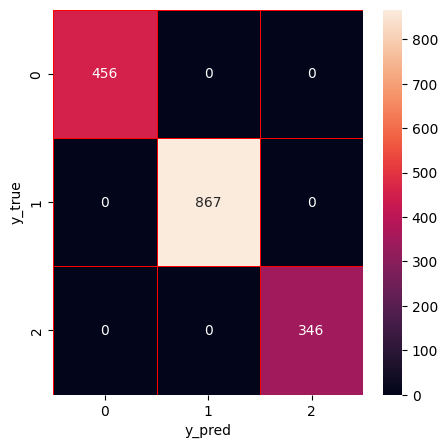

In [65]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of XGBoost using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [66]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:06<00:00,  3.22trial/s, best loss: -1.0]
XGBoost: Hyperopt estimated optimum {'learning_rate': -1.6195990081121767, 'max_depth': 68.0, 'n_estimators': 60.0}


Accuracy of XGBoost: 1.0
Precision of XGBoost: 1.0
Recall of XGBoost: 1.0
F1-score of XGBoost: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00       867
           2       1.00      1.00      1.00       346

    accuracy                           1.00      1669
   macro avg       1.00      1.00      1.00      1669
weighted avg       1.00      1.00      1.00      1669



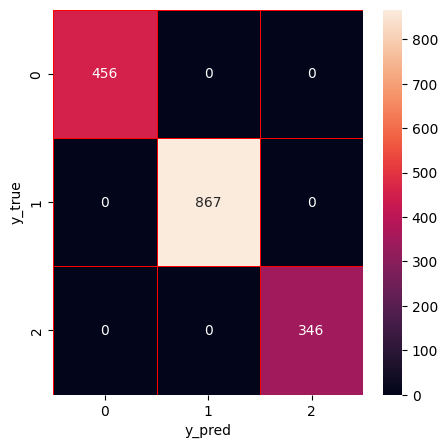

In [67]:
xg = xgb.XGBClassifier(learning_rate=1.6195990081121767, n_estimators = 60, max_depth = 68)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [68]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

#### Apply RF

Accuracy of RF: 1.0
Precision of RF: 1.0
Recall of RF: 1.0
F1-score of RF: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00       867
           2       1.00      1.00      1.00       346

    accuracy                           1.00      1669
   macro avg       1.00      1.00      1.00      1669
weighted avg       1.00      1.00      1.00      1669



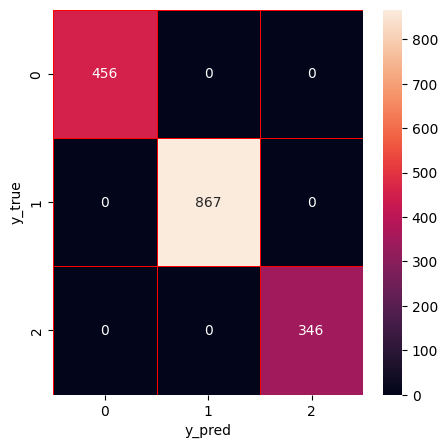

In [69]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of random forest using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [70]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:19<00:00,  1.01trial/s, best loss: -1.0]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 28.0, 'max_features': 4.0, 'min_samples_leaf': 1.0, 'min_samples_split': 7.0, 'n_estimators': 152.0}


Accuracy of RF: 1.0
Precision of RF: 1.0
Recall of RF: 1.0
F1-score of RF: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00       867
           2       1.00      1.00      1.00       346

    accuracy                           1.00      1669
   macro avg       1.00      1.00      1.00      1669
weighted avg       1.00      1.00      1.00      1669



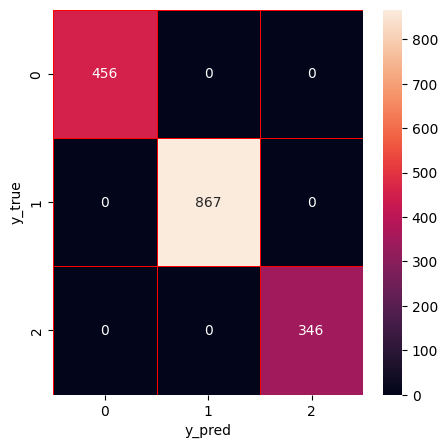

In [71]:
rf_hpo = RandomForestClassifier(n_estimators = 152, min_samples_leaf = 1, max_depth = 28, min_samples_split = 7, max_features = 4, criterion = 'gini')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [72]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

#### Apply DT

Accuracy of DT: 1.0
Precision of DT: 1.0
Recall of DT: 1.0
F1-score of DT: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00       867
           2       1.00      1.00      1.00       346

    accuracy                           1.00      1669
   macro avg       1.00      1.00      1.00      1669
weighted avg       1.00      1.00      1.00      1669



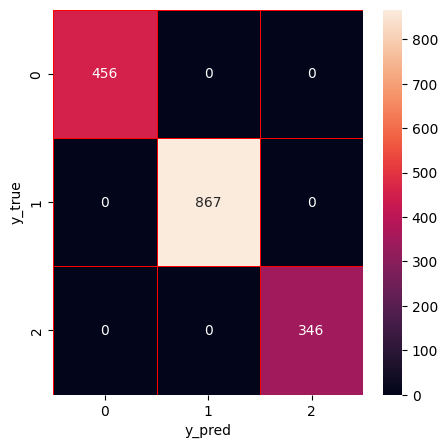

In [73]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of decision tree using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [75]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [00:02<00:00, 23.93trial/s, best loss: -1.0]
Decision tree: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 41.0, 'max_features': 9.0, 'min_samples_leaf': 8.0, 'min_samples_split': 3.0}


Accuracy of DT: 1.0
Precision of DT: 1.0
Recall of DT: 1.0
F1-score of DT: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00       867
           2       1.00      1.00      1.00       346

    accuracy                           1.00      1669
   macro avg       1.00      1.00      1.00      1669
weighted avg       1.00      1.00      1.00      1669



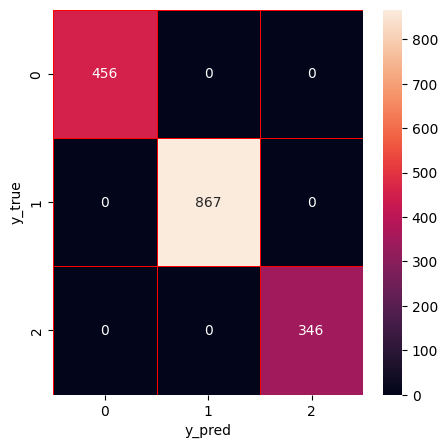

In [76]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 8, max_depth = 41, min_samples_split = 3, max_features = 9, criterion = 'gini')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [77]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

Accuracy of ET: 1.0
Precision of ET: 1.0
Recall of ET: 1.0
F1-score of ET: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00       867
           2       1.00      1.00      1.00       346

    accuracy                           1.00      1669
   macro avg       1.00      1.00      1.00      1669
weighted avg       1.00      1.00      1.00      1669



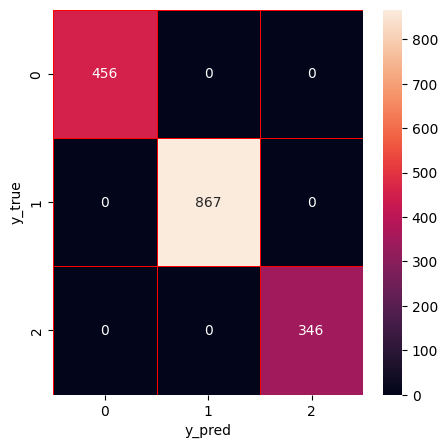

In [78]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of extra trees using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [79]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:12<00:00,  1.57trial/s, best loss: -1.0]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 44.0, 'max_features': 7.0, 'min_samples_leaf': 4.0, 'min_samples_split': 10.0, 'n_estimators': 59.0}


Accuracy of ET: 1.0
Precision of ET: 1.0
Recall of ET: 1.0
F1-score of ET: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00       867
           2       1.00      1.00      1.00       346

    accuracy                           1.00      1669
   macro avg       1.00      1.00      1.00      1669
weighted avg       1.00      1.00      1.00      1669



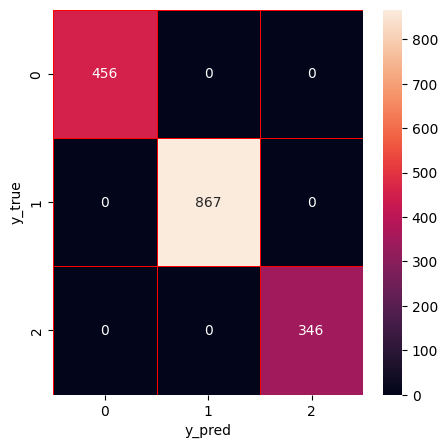

In [80]:
et_hpo = ExtraTreesClassifier(n_estimators = 59, min_samples_leaf = 4, max_depth = 44, min_samples_split = 10, max_features = 7, criterion = 'entropy')
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [81]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

### Apply Stacking
The ensemble model that combines the four ML models (DT, RF, ET, XGBoost)

In [82]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,0,0,0,0
1,1,1,1,1
2,1,1,1,1
3,0,0,0,0
4,0,0,0,0


In [83]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [84]:
dt_train.shape

(7464, 1)

In [85]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 1.0
Precision of Stacking: 1.0
Recall of Stacking: 1.0
F1-score of Stacking: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00       867
           2       1.00      1.00      1.00       346

    accuracy                           1.00      1669
   macro avg       1.00      1.00      1.00      1669
weighted avg       1.00      1.00      1.00      1669



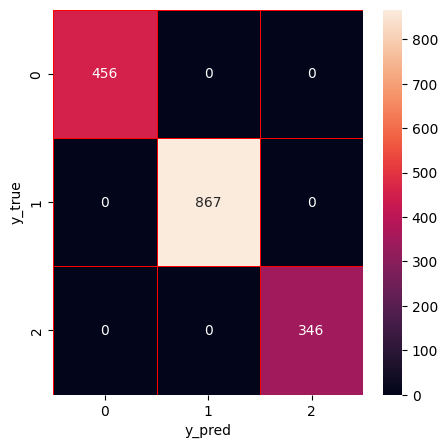

In [86]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Hyperparameter optimization (HPO) of the stacking ensemble model (XGBoost) using Bayesian optimization with tree-based Parzen estimator (BO-TPE)
Based on the GitHub repo for HPO: https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms

In [88]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|██████████| 20/20 [00:04<00:00,  4.02trial/s, best loss: -1.0]
XGBoost: Hyperopt estimated optimum {'learning_rate': -0.17216490553505023, 'max_depth': 70.0, 'n_estimators': 65.0}


Accuracy of XGBoost: 1.0
Precision of XGBoost: 1.0
Recall of XGBoost: 1.0
F1-score of XGBoost: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00       867
           2       1.00      1.00      1.00       346

    accuracy                           1.00      1669
   macro avg       1.00      1.00      1.00      1669
weighted avg       1.00      1.00      1.00      1669



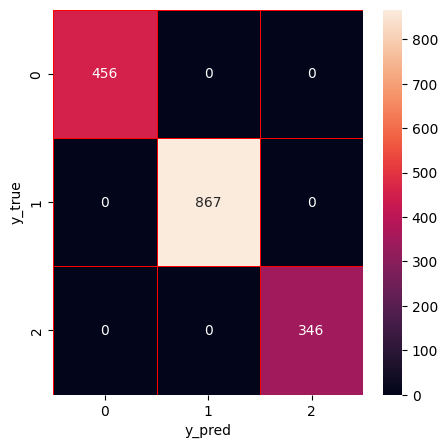

In [89]:
xg = xgb.XGBClassifier(learning_rate=0.17216490553505023, n_estimators = 65, max_depth = 70)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly-based IDS

### Generate the BOT datasets for unknown attack detection

In [90]:
df=pd.read_csv('./20180221/02-21-2018_small_km.csv')

In [91]:
df.Label.value_counts()

Label
1    4331
0    2281
2    1730
Name: count, dtype: int64

In [93]:
df1 = df[df['Label'] != 2]
df1['Label'][df1['Label'] > 0] = 1
df1.to_csv('./20180221/02-21-2018_small_km_without_LOIC.csv',index=0)

C:\Users\Admin\AppData\Local\Temp\ipykernel_10056\2742587256.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df1['Label'][df1['Label'] > 0] = 1
C:\Users\Admin\AppData\Local\Temp\ipykernel_10056\2742587256.py:2: SettingWithCopyWarning: 
A

In [94]:
df2 = df[df['Label'] == 2]
df2['Label'][df2['Label'] == 2] = 1
df2.to_csv('./20180221/02-21-2018_small_km_LOIC.csv',index=0)

C:\Users\Admin\AppData\Local\Temp\ipykernel_10056\3127232144.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df2['Label'][df2['Label'] == 2] = 1
C:\Users\Admin\AppData\Local\Temp\ipykernel_10056\3127232144.py:2: SettingWithCopyWarning: 


### Read the generated datasets for unknown attack detection

In [103]:
df1 = pd.read_csv('./20180221/02-21-2018_small_km_without_LOIC.csv')

In [104]:
df2 = pd.read_csv('./20180221/02-21-2018_small_km_LOIC.csv')

In [105]:
features = df1.drop(['Label'],axis=1).dtypes[df1.dtypes != 'object'].index
df1[features] = df1[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df2[features] = df2[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
df1 = df1.fillna(0)
df2 = df2.fillna(0)

In [106]:
df1.Label.value_counts()

Label
1    4331
0    2281
Name: count, dtype: int64

In [107]:
df2.Label.value_counts()

Label
1    1730
Name: count, dtype: int64

In [108]:
df2p=df1[df1['Label']==0]
df2pp=df2p.sample(n=None, frac=1730/2281, replace=False, weights=None, random_state=None, axis=0)
df2=pd.concat([df2, df2pp])

In [109]:
df2.Label.value_counts()

Label
1    1730
0    1730
Name: count, dtype: int64

In [110]:
df = pd.concat([df1, df2], ignore_index=True)

In [111]:
df.shape

(10072, 79)

In [112]:
X = df.drop(['Label'],axis=1) .values
y = df.iloc[:, -1].values.reshape(-1,1)
y.shape


(10072, 1)

In [113]:
y=np.ravel(y)
y.shape

(10072,)

In [114]:
pd.Series(y).value_counts()

1    6061
0    4011
Name: count, dtype: int64

In [115]:
y.shape

(10072,)

### Feature engineering (IG, FCBF, and KPCA)

#### Feature selection by information gain (IG)

In [116]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X, y)

In [117]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [118]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [119]:
X_fs = df[fs].values

In [120]:
X_fs.shape

(10072, 46)

In [121]:
y.shape

(10072,)

In [122]:
X_fs

array([[-2.58865677e-02, -8.59095208e-01, -9.26744223e-01, ...,
        -1.89239998e-01, -2.72663766e-01, -4.99394306e-02],
       [-2.61594368e-02, -8.59095208e-01, -9.26744223e-01, ...,
        -1.82489344e-01, -2.66183746e-01, -5.01382544e-02],
       [-2.57107372e-02, -8.59095208e-01, -9.26744223e-01, ...,
        -1.93093585e-01, -2.76362862e-01, -4.98113131e-02],
       ...,
       [-2.96362366e-02,  1.34716626e+00,  1.27208549e+00, ...,
        -1.09417074e-01, -1.32302344e-01, -4.92692311e-02],
       [ 1.61920870e+00, -7.83586794e-01, -5.50473898e-01, ...,
        -2.75401500e-01, -3.55371058e-01,  1.80771574e+01],
       [ 4.66649729e+01, -8.59095208e-01, -9.26744223e-01, ...,
        -2.75413356e-01, -3.55382438e-01,  3.39709784e+01]])

#### Feature selection by Fast Correlation Based Filter (FCBF)

The module is imported from the GitHub repo: https://github.com/SantiagoEG/FCBF_module

In [123]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [124]:
X_fss = fcbf.fit_transform(X_fs,y)

In [125]:
X_fss.shape

(10072, 20)

In [126]:
X_fss

array([[-0.8420697 , -0.88087554, -0.88087554, ..., -0.75476663,
        -0.75476663, -0.93479208],
       [-0.8420697 , -0.88087554, -0.88087554, ..., -0.75476663,
        -0.75476663, -0.93479208],
       [-0.8420697 , -0.88087554, -0.88087554, ..., -0.75476663,
        -0.75476663, -0.93479208],
       ...,
       [ 0.38628533,  0.49425115,  0.49425115, ...,  0.10527137,
         0.10527137,  0.56152661],
       [-0.8420697 , -0.88087554, -0.88087554, ..., -0.75476663,
        -0.75476663, -0.93479208],
       [-0.8420697 , -0.88087554, -0.88087554, ..., -0.75476663,
        -0.75476663, -0.93479208]])

####  kernel principal component analysis (KPCA)

In [127]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components = 10, kernel = 'rbf')
kpca.fit(X_fss, y)
X_kpca = kpca.transform(X_fss)

# from sklearn.decomposition import PCA
# kpca = PCA(n_components = 10)
# kpca.fit(X_fss, y)
# X_kpca = kpca.transform(X_fss)

### Train-test split after feature selection

In [128]:
X_train = X_kpca[:len(df1)]
y_train = y[:len(df1)]
X_test = X_kpca[len(df1):]
y_test = y[len(df1):]

In [129]:
pd.Series(y_train).value_counts()

1    4331
0    2281
Name: count, dtype: int64

In [130]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(n_jobs=-1,sampling_strategy={0:4331})
X_train, y_train = smote.fit_resample(X_train, y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [131]:
pd.Series(y_train).value_counts()

1    4331
0    4331
Name: count, dtype: int64

In [132]:
pd.Series(y_test).value_counts()

1    1730
0    1730
Name: count, dtype: int64

### Apply the cluster labeling (CL) k-means method

In [133]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN,MeanShift
from sklearn.cluster import SpectralClustering,AgglomerativeClustering,AffinityPropagation,Birch,MiniBatchKMeans,MeanShift 
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import classification_report
from sklearn import metrics

In [134]:
def CL_kmeans(X_train, X_test, y_train, y_test,n,b=100):
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y_test,result2)
    print(str(acc))
    print(cm)

In [136]:
CL_kmeans(X_train, X_test, y_train, y_test, 8)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1730
           1       0.99      1.00      1.00      1730

    accuracy                           1.00      3460
   macro avg       1.00      1.00      1.00      3460
weighted avg       1.00      1.00      1.00      3460

0.9950867052023121
[[1713   17]
 [   0 1730]]


### Hyperparameter optimization of CL-k-means
Tune "k"

In [137]:
#Hyperparameter optimization by BO-GP
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn import metrics

space  = [Integer(2, 50, name='n_clusters')]
@use_named_args(space)
def objective(**params):
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    cm=metrics.accuracy_score(y_test,result2)
    print(str(n)+" "+str(cm))
    return (1-cm)
from skopt import gp_minimize
import time
t1=time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=0)
t2=time.time()
print(t2-t1)
print("Best score=%.4f" % (1-res_gp.fun))
print("""Best parameters: n_clusters=%d""" % (res_gp.x[0]))

30 0.4997109826589595
43 0.5
43 0.5
43 0.5
32 0.5
20 0.5
16 0.5
5 0.9898843930635838
15 0.9884393063583815
25 0.5
2 0.9719653179190751


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2] before, using random point [42]
  warnings.warn(


42 0.5


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2] before, using random point [16]
  warnings.warn(


16 0.9898843930635838


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2] before, using random point [18]
  warnings.warn(


18 0.5


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2] before, using random point [8]
  warnings.warn(


8 0.9898843930635838
4 0.4997109826589595


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2] before, using random point [10]
  warnings.warn(


10 0.5


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2] before, using random point [38]
  warnings.warn(


38 0.5


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2] before, using random point [17]
  warnings.warn(


17 0.9722543352601156


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2] before, using random point [11]
  warnings.warn(


11 0.5
14.144593477249146
Best score=0.9899
Best parameters: n_clusters=5


In [138]:
#Hyperparameter optimization by BO-TPE
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics

def objective(params):
    params = {
        'n_clusters': int(params['n_clusters']), 
    }
    km_cluster = MiniBatchKMeans(batch_size=100, **params)
    n=params['n_clusters']
    
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    score=metrics.accuracy_score(y_test,result2)
    print(str(params['n_clusters'])+" "+str(score))
    return {'loss':1-score, 'status': STATUS_OK }
space = {
    'n_clusters': hp.quniform('n_clusters', 2, 50, 1),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

22 0.5                                                
38 0.5                                                           
49 0.5                                                           
10 0.8653179190751445                                            
25 0.9867052023121388                                                            
44 0.5                                                                            
17 0.5                                                                            
29 0.5                                                                            
18 0.9598265895953757                                                             
47 0.5                                                                            
33 0.5                                                                             
40 0.8973988439306358                                                              
21 0.9670520231213873                                                             

In [141]:
# Từ BO-GP
print("Kết quả với BO-GP n_clusters=5")
CL_kmeans(X_train, X_test, y_train, y_test, n=5)

Kết quả với BO-GP n_clusters=5
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1730
           1       0.99      0.99      0.99      1730

    accuracy                           0.99      3460
   macro avg       0.99      0.99      0.99      3460
weighted avg       0.99      0.99      0.99      3460

0.9901734104046243
[[1713   17]
 [  17 1713]]


### Apply the CL-k-means model with biased classifiers

In [142]:
# Từ BO-TPE
print("Kết quả với BO-TPE n_clusters=3")
CL_kmeans(X_train, X_test, y_train, y_test, n=3)

Kết quả với BO-TPE n_clusters=3
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1730
           1       0.99      0.99      0.99      1730

    accuracy                           0.99      3460
   macro avg       0.99      0.99      0.99      3460
weighted avg       0.99      0.99      0.99      3460

0.9895953757225433
[[1713   17]
 [  19 1711]]


### Apply the CL-k-means model with biased classifiers

In [143]:
# Only a sample code to show the logic. It needs to work on the entire dataset to generate sufficient training samples for biased classifiers
def Anomaly_IDS(X_train, X_test, y_train, y_test,n,b=100):
    # CL-kmeans
    km_cluster = MiniBatchKMeans(n_clusters=n,batch_size=b)
    result = km_cluster.fit_predict(X_train)
    result2 = km_cluster.predict(X_test)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y_train)):
            if result[i]==v:
                if y_train[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y_test)):
        if result2[v] in list1:
            result2[v]=0
        elif result2[v] in list2:
            result2[v]=1
        else:
            print("-1")
    print(classification_report(y_test, result2))
    cm=confusion_matrix(y_test,result2)
    acc=metrics.accuracy_score(y2,result2)
    print(str(acc))
    print(cm)
    
    #Biased classifier construction
    count=0
    print(len(y))
    a=np.zeros(n)
    b=np.zeros(n)
    FNL=[]
    FPL=[]
    for v in range(0,n):
        al=[]
        bl=[]
        for i in range(0,len(y)):   
            if result[i]==v:        
                if y[i]==1:        #label 1
                    a[v]=a[v]+1
                    al.append(i)
                else:             #label 0
                    b[v]=b[v]+1
                    bl.append(i)
        if a[v]<=b[v]:
            FNL.extend(al)
        else:
            FPL.extend(bl)
        #print(str(v)+"="+str(a[v]/(a[v]+b[v])))
        
    dffp=df.iloc[FPL, :]
    dffn=df.iloc[FNL, :]
    dfva0=df[df['Label']==0]
    dfva1=df[df['Label']==1]
    
    dffpp=dfva1.sample(n=None, frac=len(FPL)/dfva1.shape[0], replace=False, weights=None, random_state=None, axis=0)
    dffnp=dfva0.sample(n=None, frac=len(FNL)/dfva0.shape[0], replace=False, weights=None, random_state=None, axis=0)
    
    dffp_f=pd.concat([dffp, dffpp])
    dffn_f=pd.concat([dffn, dffnp])
    
    Xp = dffp_f.drop(['Label'],axis=1)  
    yp = dffp_f.iloc[:, -1].values.reshape(-1,1)
    yp=np.ravel(yp)

    Xn = dffn_f.drop(['Label'],axis=1)  
    yn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    yn=np.ravel(yn)
    
    rfp = RandomForestClassifier(random_state = 0)
    rfp.fit(Xp,yp)
    rfn = RandomForestClassifier(random_state = 0)
    rfn.fit(Xn,yn)

    dffnn_f=pd.concat([dffn, dffnp])
    
    Xnn = dffn_f.drop(['Label'],axis=1)  
    ynn = dffn_f.iloc[:, -1].values.reshape(-1,1)
    ynn=np.ravel(ynn)

    rfnn = RandomForestClassifier(random_state = 0)
    rfnn.fit(Xnn,ynn)

    X2p = df2.drop(['Label'],axis=1) 
    y2p = df2.iloc[:, -1].values.reshape(-1,1)
    y2p=np.ravel(y2p)

    result2 = km_cluster.predict(X2p)

    count=0
    a=np.zeros(n)
    b=np.zeros(n)
    for v in range(0,n):
        for i in range(0,len(y)):
            if result[i]==v:
                if y[i]==1:
                    a[v]=a[v]+1
                else:
                    b[v]=b[v]+1
    list1=[]
    list2=[]
    l1=[]
    l0=[]
    for v in range(0,n):
        if a[v]<=b[v]:
            list1.append(v)
        else: 
            list2.append(v)
    for v in range(0,len(y2p)):
        if result2[v] in list1:
            result2[v]=0
            l0.append(v)
        elif result2[v] in list2:
            result2[v]=1
            l1.append(v)
        else:
            print("-1")
    print(classification_report(y2p, result2))
    cm=confusion_matrix(y2p,result2)
    print(cm)